In [59]:
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
from numpy import array
import numpy as np


In [60]:
fn = '2023-wimbledon-1401'
df = read_csv('2024c/processed_data/'+fn, index_col=[0])
ori_df = read_csv('2024c/processed_data/origin/'+fn)
df.columns


Index(['match_id', 'elapsed_time', 'p1_sets', 'p2_sets', 'p1_games',
       'p2_games', 'p1_score', 'p2_score', 'server', 'serve_no',
       'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor',
       'set_victor', 'p1_ace', 'p2_ace', 'p1_winner', 'p2_winner',
       'p1_double_fault', 'p2_double_fault', 'p1_unf_err', 'p2_unf_err',
       'p1_net_pt', 'p2_net_pt', 'p1_net_pt_won', 'p2_net_pt_won',
       'p1_break_pt', 'p2_break_pt', 'p1_break_pt_won', 'p2_break_pt_won',
       'p1_break_pt_missed', 'p2_break_pt_missed', 'p1_distance_run',
       'p2_distance_run', 'rally_count', 'speed_mph', 'serve_width',
       'serve_depth', 'return_depth', 'winner_shot_type'],
      dtype='object')

In [61]:
# 找特征: ：分差，赛点类别，连胜次数，是否投球
score_dif_p1 = df['p1_points_won'] - df['p2_points_won']
score_dif_p2 = df['p2_points_won'] - df['p1_points_won']
# 标准化
score_dif_p1 = (score_dif_p1-score_dif_p1.mean())/score_dif_p1.std()
score_dif_p2 = (score_dif_p2-score_dif_p2.mean())/score_dif_p2.std()

p1_break_points = df['p1_break_pt']
p2_break_points = df['p2_break_pt']
p1_break_points_won = df['p1_break_pt_won']
p2_break_points_won = df['p2_break_pt_won']
p1_ad = []
for i in ori_df['p1_score']:
    if i == 'AD':
        p1_ad.append(1)
    else:
        p1_ad.append(0)
p1_ad = array(p1_ad, dtype=np.int8)
p2_ad = []
for i in ori_df['p2_score']:
    if i == 'AD':
        p2_ad.append(1)
    else:
        p2_ad.append(0)
p2_ad = array(p2_ad, dtype=np.int8)


# 投球
server = df['server']
server_p1, server_p2 = [0]*len(server), [0]*len(server)
for i,j in enumerate(server.tolist()):
    if j == 1: server_p1[i] = 1
    else: server_p2[i] = 1
server_p1, server_p2 = array(server_p1), array(server_p2 )


In [62]:
# 连胜
p1_score = df['p1_score']
p2_score = df['p2_score']

from itertools import pairwise
def comble_df(p_score):
    res = [0]
    # p_score = [0,0,0,1,1,2,2,3,4,5,6,6,6,6,7,7,8,9,0,1]
    # correct = [0,0,0,0,0,0,0,0,1,2,3,0,0,0,0,0,0,1,0,0]
    cnt = 0
    for i,j in pairwise(p_score):
        if j > i:
            cnt += 1
        if i == j or j == 0:
            cnt = 0
        if cnt > 0:
            res.append(cnt-1)
        else:
            res.append(0)

    # print(correct)
    # print(res)
    # assert res == correct
    return array(res, dtype=np.int8)
p1_comble = comble_df(p1_score)
p2_comble = comble_df(p2_score)
# 归一化
p1_comble = (p1_comble-p1_comble.mean())/p1_comble.std()
p2_comble = (p2_comble-p2_comble.mean())/p2_comble.std()
# plt.plot(p1_comble, color='red')
# plt.plot(p2_comble, color='blue')

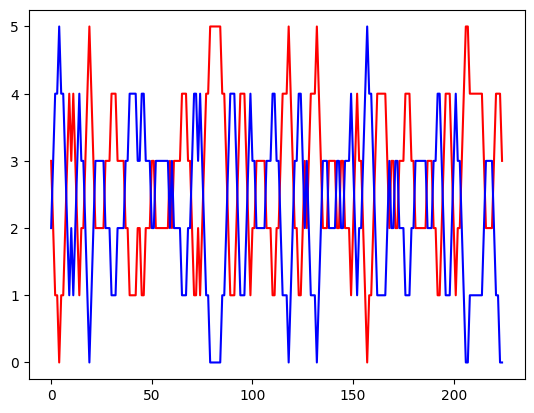

In [63]:
# 标签: 接下来5场胜率
def win_possiblity(window_size=5):
    point_victor = df['point_victor'].tolist()
    n = len(point_victor)
    point_victor += [1,1]+[0]*(window_size-2)
    res1, res2 = [], []
    for i in range(n):
        cnt1 = cnt2 = 0
        for j in point_victor[i:i+window_size]:
            if j == 1:
                cnt1 += 1
            if j == 2:
                cnt2 += 1
        res1.append(cnt1)
        res2.append(cnt2)
    return array(res1,dtype=np.int8), array(res2,dtype=np.int8)

p1_win_possiblity, p2_win_possiblity = win_possiblity()
plt.plot(p1_win_possiblity, color='red')
plt.plot(p2_win_possiblity, color='blue')

In [64]:
n = len(score_dif_p1)
for i in [score_dif_p1, score_dif_p2, server_p1, server_p2, p1_ad, p2_ad, p1_comble, p2_comble, p1_break_points, p2_break_points, p1_break_points_won, p2_break_points_won, p1_win_possiblity, p2_win_possiblity]:
    print(i.dtype)
    assert n == len(i)

float64
float64
int32
int32
int8
int8
float64
float64
int64
int64
int64
int64
int8
int8


In [65]:
heatdf = DataFrame(
    dict(zip(['score_dif_p1','score_dif_p2','server_p1','server_p2','p1_ad','p2_ad','p1_comble','p2_comble','p1_break_points','p2_break_points','p1_break_points_won','p2_break_points_won','p1_win_possiblity','p2_win_possiblity'],
    [score_dif_p1, score_dif_p2, server_p1, server_p2, p1_ad, p2_ad, p1_comble, p2_comble, p1_break_points, p2_break_points, p1_break_points_won, p2_break_points_won, p1_win_possiblity, p2_win_possiblity]))
    )

In [66]:
heatdf.head()

,score_dif_p1,score_dif_p2,server_p1,server_p2,p1_ad,p2_ad,p1_comble,p2_comble,p1_break_points,p2_break_points,p1_break_points_won,p2_break_points_won,p1_win_possiblity,p2_win_possiblity
3788,-0.810852,0.810852,0,1,0,0,-0.420574,-0.381385,0,0,0,0,3,2
3789,-0.638412,0.638412,0,1,0,0,-0.420574,-0.381385,0,0,0,0,2,3
3790,-0.810852,0.810852,0,1,0,0,1.510632,-0.381385,0,0,0,0,1,4
3791,-0.638412,0.638412,0,1,0,0,-0.420574,-0.381385,0,0,0,0,1,4
3792,-0.810852,0.810852,0,1,0,0,-0.420574,-0.381385,1,0,0,0,0,5


In [67]:
# import seaborn as sns
# plt.figure(figsize=(35,30))
# sns.heatmap(heatdf.corr(),annot=True,annot_kws={"fontsize":20})
# plt.xticks(fontsize=50,rotation=90)
# plt.yticks(fontsize=50,rotation=0)
# plt.show()

In [68]:
heatdf.to_csv('2024c/traintestds/'+fn)